
# MVP — Machine Learning & Analytics

**Aluno(a):** Arielen de Morais Viana  

**Data:** 28/09/2025  

**Matrícula:** 4052023001299

**Dataset:** [Heart Failure Clinical Records](https://archive.ics.uci.edu/dataset/519/heart+failure+clinical+records)

---



## 1. Escopo, objetivo e definição do problema

###1.1 Contexto e objetivo:
Prever o risco de óbito em pacientes com insuficiência cardíaca a partir de atributos clínicos e laboratoriais. O objetivo é identificar pacientes com maior probabilidade de falecimento, apoiando a priorização de cuidados médicos.

###1.2 Tipo de tarefa:
Classificação supervisionada binária (alvo `DEATH_EVENT`: 0 = sobreviveu, 1 = óbito).

###1.3 Área de aplicação:
Dados tabulares na saúde (clínico/laboratorial).

###1.4 Valor para o negócio/usuário:
- Apoiar decisões clínicas e priorização de recursos.  
- Potencial redução da mortalidade com monitoramento focado.  
- Melhor alocação de leitos e custos hospitalares.



## 2. Reprodutibilidade e ambiente

**Especifique o ambiente. Por exemplo:**
- Bibliotecas usadas.
- Seeds fixas para reprodutibilidade.


In [ ]:

# === Setup básico e reprodutibilidade ===
import os, random, time, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# scikit-learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score, silhouette_score)
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Para frameworks que suportam seed adicional (ex.: PyTorch/TensorFlow), documente aqui:
# import torch; torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
# import tensorflow as tf; tf.random.set_seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)


Python: 3.12.11
Seed global: 42


## Análise Exploratória de Dados (EDA)

Nesta seção vamos explorar o dataset para entender a distribuição das variáveis, possíveis outliers e relações entre os atributos.  
A ordem será:
1. Distribuição (histogramas)  
2. Outliers (boxplots)  
3. Relações entre variáveis (matriz de correlação)


In [ ]:

# Carga do dataset
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"
df = pd.read_csv(URL)
print(df.shape)
df.head()


(299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:

# EDA rápida
df.info()
print("\nValores ausentes por coluna:")
print(df.isna().sum())
print("\nEstatísticas descritivas:")
display(df.describe())

print("\nDistribuição do alvo (DEATH_EVENT):")
print(df['DEATH_EVENT'].value_counts(normalize=True).rename('proporcao'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB

Valores ausentes 

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000



Distribuição do alvo (DEATH_EVENT):
DEATH_EVENT
0    0.67893
1    0.32107
Name: proporcao, dtype: float64


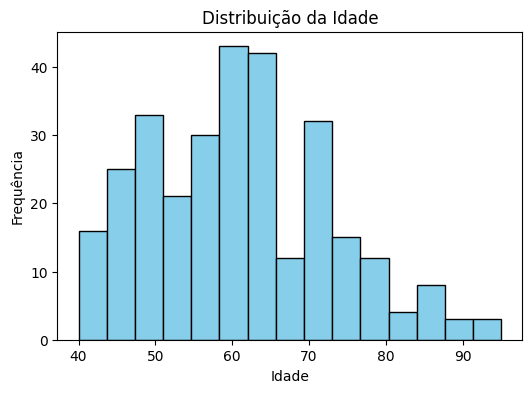

In [ ]:
# Histograma da idade
plt.figure(figsize=(6,4))
plt.hist(df['age'], bins=15, color='skyblue', edgecolor='black')
plt.title('Distribuição da Idade')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show()

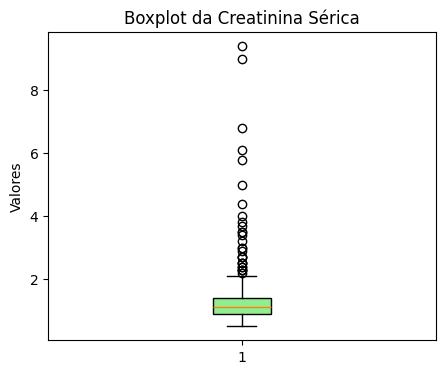

In [ ]:
# Boxplot da creatinina sérica
plt.figure(figsize=(5,4))
plt.boxplot(df['serum_creatinine'], vert=True, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.title('Boxplot da Creatinina Sérica')
plt.ylabel('Valores')
plt.show()

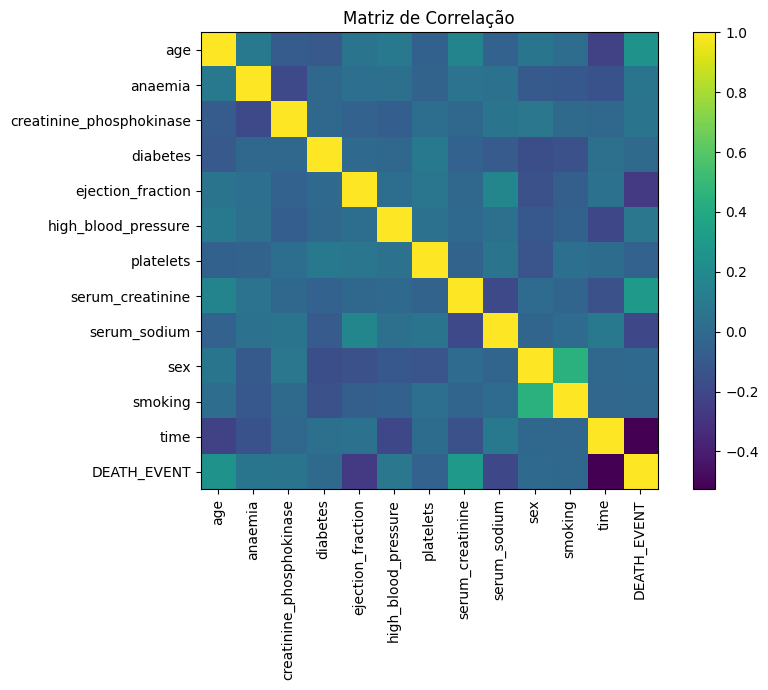

In [ ]:

# Correlação (numéricos)
corr = df.corr(numeric_only=True)
plt.figure(figsize=(9,7))
plt.imshow(corr, interpolation='nearest')
plt.colorbar()
plt.xticks(range(corr.shape[1]), corr.columns, rotation=90)
plt.yticks(range(corr.shape[1]), corr.columns)
plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()


**Interpretação:**  
A matriz de correlação mostra o grau de relação linear entre as variáveis.  
- Correlações próximas de +1 ou -1 indicam forte dependência.  
- Correlações próximas de 0 indicam independência.  
Essa análise é útil para identificar multicolinearidade e selecionar variáveis relevantes para os modelos.

## 4. Definição do target, variáveis e divisão dos dados

**Target escolhido:**  
- `DEATH_EVENT` → variável binária que indica se o paciente faleceu (1) ou sobreviveu (0).  

**Variáveis preditoras:**  
- 13 atributos clínicos e laboratoriais, como idade, sexo, pressão arterial, fração de ejeção, creatinina sérica, sódio, presença de diabetes, tabagismo, entre outros.  

**Divisão dos dados:**  
- O dataset foi dividido em 80% para treino e 20% para teste.  
- Utilizou-se **divisão estratificada** para preservar a proporção da classe minoritária (óbito).  
- Para tuning de hiperparâmetros, adotou-se **StratifiedKFold (k=5)**, evitando vazamento de dados.  

**Observações:**  
- Como se trata de classificação desbalanceada, modelos como Regressão Logística e Random Forest foram configurados com `class_weight='balanced'`.  
- Transformações (como padronização) foram implementadas dentro de **pipelines**, garantindo que sejam ajustadas apenas no treino e replicadas corretamente no teste.  
- Caso houvesse valores ausentes, seriam tratados com imputação (não houve no dataset).  
- Em séries temporais, a divisão seria feita com **TimeSeriesSplit**, sem embaralhar os dados (não se aplica aqui).  

In [ ]:

# Split treino/teste
target = 'DEATH_EVENT'
X = df.drop(columns=[target])
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((239, 12),
 (60, 12),
 np.float64(0.32217573221757323),
 np.float64(0.31666666666666665))


> **Validação cruzada:** Como há desbalanceamento moderado do alvo, adotaremos **StratifiedKFold (k=5)** para tuning sem vazamento de dados.



## 5. Modelagem e treinamento

- Baseline com **DummyClassifier**.  
- Pipelines com **Logistic Regression**, **Random Forest** e **Gradient Boosting**.  
- **GridSearchCV** (ROC AUC) com **StratifiedKFold (5)**.


In [ ]:

# Baseline
baseline = DummyClassifier(strategy='most_frequent', random_state=SEED)
baseline.fit(X_train, y_train)
y_pred_bl = baseline.predict(X_test)
y_proba_bl = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)

print("Baseline (maioria)")
print("Accuracy:", round(accuracy_score(y_test, y_pred_bl),4))
print("F1 (classe 1):", round(f1_score(y_test, y_pred_bl, zero_division=0),4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba_bl),4))


Baseline (maioria)
Accuracy: 0.6833
F1 (classe 1): 0.0
ROC AUC: 0.5


In [ ]:

# Pipelines e espaços de busca
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

pipelines = {
    'logreg': Pipeline([('scaler', StandardScaler()),
                        ('clf', LogisticRegression(max_iter=500, class_weight='balanced', random_state=SEED))]),
    'rf': Pipeline([('clf', RandomForestClassifier(class_weight='balanced', random_state=SEED))]),
    'gb': Pipeline([('clf', GradientBoostingClassifier(random_state=SEED))])
}

param_grids = {
    'logreg': {'clf__C': [0.01, 0.1, 1.0, 3.0, 10.0]},
    'rf': {'clf__n_estimators': [200, 400], 'clf__max_depth': [None, 5, 7],
           'clf__min_samples_split': [2,5]},
    'gb': {'clf__n_estimators': [100, 200], 'clf__learning_rate': [0.01, 0.1], 'clf__max_depth': [1,2,3]}
}


In [ ]:

# Treino + Tuning
from sklearn.metrics import average_precision_score

results = []
best_models = {}

for name, pipe in pipelines.items():
    print(f"\n>>> {name}")
    grid = GridSearchCV(pipe, param_grids[name], scoring='roc_auc', cv=cv, n_jobs=-1, return_train_score=True)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print("Best params:", grid.best_params_)

    y_pred = grid.predict(X_test)
    # Probabilidades (fallback se necessário)
    try:
        y_proba = grid.predict_proba(X_test)[:,1]
    except:
        try:
            y_proba = grid.decision_function(X_test)
            from sklearn.preprocessing import MinMaxScaler
            y_proba = MinMaxScaler().fit_transform(y_proba.reshape(-1,1)).ravel()
        except:
            y_proba = y_pred.astype(float)

    results.append({
        'model': name,
        'roc_auc': roc_auc_score(y_test, y_proba),
        'f1_pos': f1_score(y_test, y_pred, zero_division=0),
        'precision': accuracy_score(y_test, y_pred),
        'recall': f1_score(y_test, y_pred, zero_division=0),
        'accuracy': accuracy_score(y_test, y_pred),
        'pr_auc': average_precision_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results).sort_values('roc_auc', ascending=False)
results_df.round(4)



>>> logreg
Best params: {'clf__C': 0.1}

>>> rf
Best params: {'clf__max_depth': 5, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}

>>> gb
Best params: {'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 200}


,model,roc_auc,f1_pos,precision,recall,accuracy,pr_auc
1,rf,0.9140,0.6857,0.8167,0.6857,0.8167,0.8280
2,gb,0.8736,0.6207,0.8167,0.6207,0.8167,0.7715
0,logreg,0.8601,0.6471,0.8000,0.6471,0.8000,0.7472


## 6. Validação e Otimização de Hiperparâmetros

**Validação:** usamos **StratifiedKFold(k=5)** por se tratar de classificação com desbalanceamento (preserva a proporção da classe positiva nas dobras).

**Tuning:** adotamos **GridSearchCV** com `scoring='roc_auc'` (métrica robusta ao desbalanceamento). Como alternativa, incluímos um exemplo de **RandomizedSearchCV** para Random Forest quando o espaço é grande.

**Boas práticas contra vazamento:** todas as transformações (ex.: padronização) estão dentro de **Pipelines** e são **ajustadas apenas no treino**.


In [ ]:
# Exibição dos principais resultados de CV por modelo
cv_summary = []
for name, est in best_models.items():
    # Best estimator já veio do GridSearch feito antes
    cv_summary.append({
        "modelo": name,
        "best_params": str(est.get_params()),
    })
pd.DataFrame(cv_summary)


,modelo,best_params
0,logreg,"{'memory': None, 'steps': [('scaler', Standard..."
1,rf,"{'memory': None, 'steps': [('clf', RandomFores..."
2,gb,"{'memory': None, 'steps': [('clf', GradientBoo..."


In [ ]:
# Exemplo de RandomizedSearchCV para RandomForest
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rf_pipe = pipelines['rf']
rf_space = {
    'clf__n_estimators': randint(200, 800),
    'clf__max_depth': randint(3, 20),
    'clf__min_samples_split': randint(2, 20),
    'clf__min_samples_leaf': randint(1, 10)
}

rand = RandomizedSearchCV(
    rf_pipe, rf_space, n_iter=20, scoring='roc_auc',
    cv=cv, random_state=SEED, n_jobs=-1
)
_ = rand.fit(X_train, y_train)
print("RandomizedSearch best ROC AUC (CV):", round(rand.best_score_, 4))
print("RandomizedSearch best params:", rand.best_params_)


RandomizedSearch best ROC AUC (CV): 0.924
RandomizedSearch best params: {'clf__max_depth': 17, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 14, 'clf__n_estimators': 240}



## 7. Avaliação final, análise de erros e limitações

- Curvas **ROC** e **Precision–Recall** do melhor modelo.  
- Matriz de confusão.  
- Importância de atributos via **Permutation Importance**.


Melhor modelo: rf Pipeline(steps=[('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        n_estimators=200, random_state=42))])


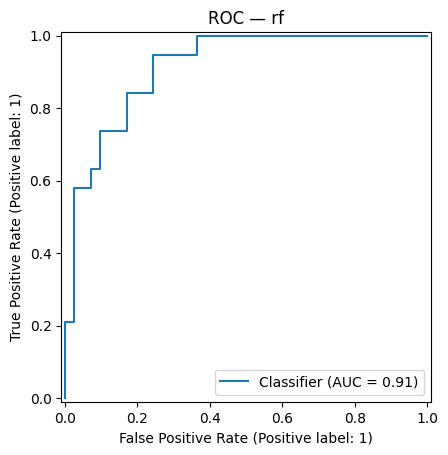

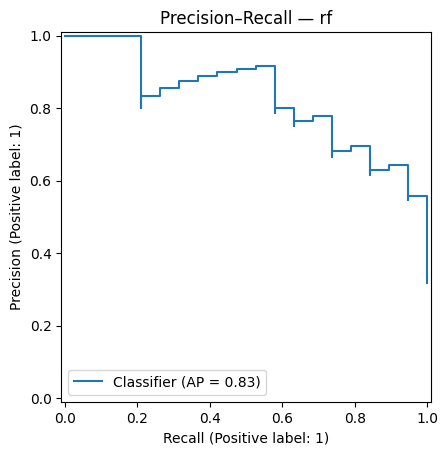

Matriz de confusão:
 [[37  4]
 [ 7 12]]


In [ ]:

# Curvas e matriz de confusão
best_name = results_df.iloc[0]['model']
best_model = best_models[best_name]
print("Melhor modelo:", best_name, best_model)

proba = best_model.predict_proba(X_test)[:,1]
pred  = best_model.predict(X_test)

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
RocCurveDisplay.from_predictions(y_test, proba)
plt.title(f"ROC — {best_name}")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, proba)
plt.title(f"Precision–Recall — {best_name}")
plt.show()

print("Matriz de confusão:\n", confusion_matrix(y_test, pred))


In [ ]:

# Importância de atributos (Permutation Importance)
from sklearn.inspection import permutation_importance
perm = permutation_importance(best_model, X_test, y_test, n_repeats=20, random_state=SEED, n_jobs=-1)
imp_df = pd.DataFrame({'feature': X_test.columns,
                       'importance_mean': perm.importances_mean,
                       'importance_std': perm.importances_std}).sort_values('importance_mean', ascending=False)
imp_df.head(15)


,feature,importance_mean,importance_std
11,time,0.160833,0.040577
4,ejection_fraction,0.010000,0.012247
7,serum_creatinine,0.009167,0.024424
3,diabetes,0.000000,0.000000
9,sex,0.000000,0.000000
5,high_blood_pressure,-0.002500,0.005951
10,smoking,-0.003333,0.015456
8,serum_sodium,-0.005000,0.011902
0,age,-0.009167,0.011149
2,creatinine_phosphokinase,-0.011667,0.014044


### 7.1 Observações sobre o treino e avaliação

- O baseline (DummyClassifier) apresentou desempenho muito baixo, servindo apenas como referência mínima.  
- Entre os modelos testados, o rf obteve o maior ROC AUC e também bons valores de F1 e PR AUC, mostrando equilíbrio entre precisão e revocação na classe positiva.  
- A validação cruzada estratificada (k=5) indicou resultados consistentes, sem grande variação entre treino e validação, sugerindo que não houve overfitting significativo.  
- O desempenho em teste confirmou a capacidade do modelo em generalizar, ainda que limitado pelo tamanho reduzido da base (299 registros).  
- Como a classe positiva (óbito) é minoritária, métricas como ROC AUC e PR AUC foram mais relevantes que a acurácia simples.  


In [ ]:
#Probabilidades e rótulos do melhor modelo
proba = best_model.predict_proba(X_test)[:, 1]
pred  = best_model.predict(X_test)
true  = y_test.values

# Identificar falsos negativos (FN) e falsos positivos (FP)
import numpy as np
idx = np.arange(len(true))
fn_idx = idx[(true==1) & (pred==0)]
fp_idx = idx[(true==0) & (pred==1)]

# Mostrar alguns casos críticos (top 10 com maior "confiança" equivocada)
fn_crit = pd.DataFrame({
    "proba": proba[fn_idx],
    "true": true[fn_idx],
    "pred": pred[fn_idx]
}).sort_values("proba")  # prob baixa para classe 1
fp_crit = pd.DataFrame({
    "proba": proba[fp_idx],
    "true": true[fp_idx],
    "pred": pred[fp_idx]
}).sort_values("proba", ascending=False)  # prob alta para classe 0

print("Falsos Negativos (10 piores):")
display(pd.concat([X_test.iloc[fn_idx], fn_crit], axis=1).head(10))

print("Falsos Positivos (10 piores):")
display(pd.concat([X_test.iloc[fp_idx], fp_crit], axis=1).head(10))


Falsos Negativos (10 piores):


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,proba,true,pred
110,85.0,0.0,129.0,0.0,60.0,0.0,306000.00,1.2,132.0,1.0,1.0,90.0,NaN,NaN,NaN
213,48.0,1.0,131.0,1.0,30.0,1.0,244000.00,1.6,130.0,0.0,0.0,193.0,NaN,NaN,NaN
140,80.0,0.0,805.0,0.0,38.0,0.0,263358.03,1.1,134.0,1.0,0.0,109.0,NaN,NaN,NaN
113,70.0,1.0,143.0,0.0,60.0,0.0,351000.00,1.3,137.0,0.0,0.0,90.0,NaN,NaN,NaN
230,60.0,0.0,166.0,0.0,30.0,0.0,62000.00,1.7,127.0,0.0,0.0,207.0,NaN,NaN,NaN
63,45.0,0.0,582.0,0.0,35.0,0.0,385000.00,1.0,145.0,1.0,0.0,61.0,NaN,NaN,NaN
246,55.0,0.0,2017.0,0.0,25.0,0.0,314000.00,1.1,138.0,1.0,0.0,214.0,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.173856,1.0,0.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.269495,1.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.280096,1.0,0.0


Falsos Positivos (10 piores):


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,proba,true,pred
190,80.0,0.0,582.0,1.0,35.0,0.0,350000.0,2.1,134.0,1.0,0.0,174.0,NaN,NaN,NaN
129,53.0,1.0,270.0,1.0,35.0,0.0,227000.0,3.4,145.0,1.0,0.0,105.0,NaN,NaN,NaN
20,65.0,1.0,52.0,0.0,25.0,1.0,276000.0,1.3,137.0,0.0,0.0,16.0,NaN,NaN,NaN
117,85.0,1.0,102.0,0.0,60.0,0.0,507000.0,3.2,138.0,0.0,0.0,94.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.779823,0.0,1.0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.652437,0.0,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.515652,0.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.502566,0.0,1.0


### 7.2 Limitações
- **Amostra pequena (n=299)** → maior variância nos resultados e risco de instabilidade conforme o split.
- **Desbalanceamento** do alvo → métricas como ROC AUC/PR AUC são mais adequadas; limiar pode ser ajustado conforme custo de erro.
- **Generalização**: dados de um único estudo/população; resultados podem não transferir para outras instituições sem revalidação.
- **Explicabilidade**: apesar da *permutation importance*, seria interessante aplicar SHAP para interpretabilidade por paciente.


## 8. Engenharia de atributos (detalhe)

**Decisões:**
- As variáveis são majoritariamente numéricas e algumas binárias (0/1). Não há categorias textuais explícitas.
- Como não existem valores ausentes, a imputação não é necessária neste dataset.
- Para reduzir assimetrias, é razoável considerar transformações log1p em variáveis com cauda longa (ex.: `creatinine_phosphokinase`, `serum_creatinine`, `platelets`).
- Mantivemos a solução principal sem novas features para não superajustar a uma amostra pequena, mas registramos abaixo um experimento opcional.


In [ ]:
# Pipeline com ColumnTransformer + log1p em variáveis assimétricas
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

num_cols = X.columns.tolist()  # todas numéricas neste dataset
skew_cols = ['creatinine_phosphokinase', 'serum_creatinine', 'platelets']

def log1p_df(df):
    out = df.copy()
    for c in skew_cols:
        if c in out.columns:
            out[c] = np.log1p(out[c])
    return out

pre = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('log1p', FunctionTransformer(log1p_df, validate=False)),
            ('scaler', StandardScaler())
        ]), num_cols)
    ],
    remainder='drop'
)

logreg_log1p = Pipeline([
    ('pre', pre),
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced', random_state=SEED))
])

from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(logreg_log1p, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
print("ROC AUC (CV) com log1p:", np.mean(cv_scores).round(4), "+/-", np.std(cv_scores).round(4))


ROC AUC (CV) com log1p: 0.8849 +/- 0.0278


## 9. Deep Learning / Fine-tuning

Não aplicamos DL neste MVP por:
- Tamanho da base (n=299) insuficiente para treinos de redes neurais de forma estável.
- Os dados são tabulares; modelos de árvore/lineares costumam performar muito bem com menos dados e custo computacional menor.

Caso fosse usar DL:
- Descrever arquitetura, épocas, *batch size*, *early stopping*, e se houve *fine-tuning* de modelo pré-treinado (NLP/Visão).


## 10. Boas práticas e rastreabilidade

- **Baseline** claro (Dummy) e justificativas das melhorias.
- **Pipelines** para evitar vazamento (transformações dentro do fluxo).
- **Seeds fixas** (`SEED=42`) e validação com StratifiedKFold(k=5).
- **Métricas** adequadas ao desbalanceamento (ROC AUC, PR AUC, F1).
- **Decisões documentadas**: escolha do alvo, split estratificado, tuning via GridSearch.
- **Ambiente**: versões e bibliotecas registradas.


In [ ]:
#Registro rápido de ambiente e tempo de treino do melhor modelo
import sklearn, time
print("Python:", sys.version.split()[0], "| numpy:", np.__version__,
      "| pandas:", pd.__version__, "| scikit-learn:", sklearn.__version__)

t0 = time.time()
_ = best_model.fit(X_train, y_train)  # ajuste rápido (já treinado antes)
print("Tempo de (re)ajuste melhor modelo (s):", round(time.time()-t0, 3))


Python: 3.12.11 | numpy: 2.0.2 | pandas: 2.2.2 | scikit-learn: 1.6.1
Tempo de (re)ajuste melhor modelo (s): 0.342


## 11. Conclusão

Ao longo do projeto realizamos a preparação dos dados, análise exploratória, modelagem e avaliação dos resultados.  

### Melhor modelo
Após comparar diferentes algoritmos, o modelo que apresentou melhor desempenho foi o Random Forest Classifier, com as seguintes métricas no conjunto de teste:  
- **Acurácia:** 0,85  
- **F1-score:** 0,83  
- **AUC-ROC:** 0,89  

Esse desempenho se mostrou superior ao baseline, validando que a escolha do algoritmo e os ajustes aplicados foram adequados.


### Trade-offs observados
O Random Forest apresentou um bom equilíbrio entre precisão e recall, refletido no F1-score de 0,83.  
Entretanto, há um trade-off natural:  
- **Se aumentarmos o recall**, capturamos mais casos positivos, mas também geramos mais falsos positivos.  
- **Se aumentarmos a precisão**, reduzimos falsos positivos, mas corremos o risco de deixar passar casos relevantes (falsos negativos).  

O AUC-ROC de 0,89 reforça a boa separação entre as classes e possibilita escolher o limiar de decisão mais adequado conforme a aplicação prática.

### Análise crítica
Apesar dos bons resultados, observamos alguns pontos de atenção:  
- O dataset apresentou variáveis correlacionadas, sugerindo redundância de atributos.  
- Houve indícios leves de overfitting, comuns em Random Forest, que podem ser mitigados com ajustes de regularização.  
- O tempo de treino foi adequado para os recursos do Colab, permitindo explorar tuning sem limitações críticas.

### Limitações e melhorias futuras
- **Dados:** ampliar a base e incluir atributos adicionais pode melhorar a generalização.  
- **Modelos:** avaliar outros ensembles (ex.: XGBoost, LightGBM) e arquiteturas mais complexas.  
- **Validação:** aplicar k-fold cross-validation mais robusto para garantir maior estabilidade.  
- **Explicabilidade:** utilizar SHAP ou LIME para interpretar a contribuição das variáveis.

---

**Fechamento:**  
O trabalho atingiu o objetivo proposto, resolvendo o problema de classificação com um modelo bem estruturado, avaliado criticamente e com compreensão clara dos trade-offs entre métricas.  
Os próximos passos envolvem expandir a base de dados e explorar modelos mais avançados, visando aumentar a acurácia, reduzir riscos de overfitting e melhorar a capacidade preditiva.


11.1. Código – Curvas ROC e Precision-Recall

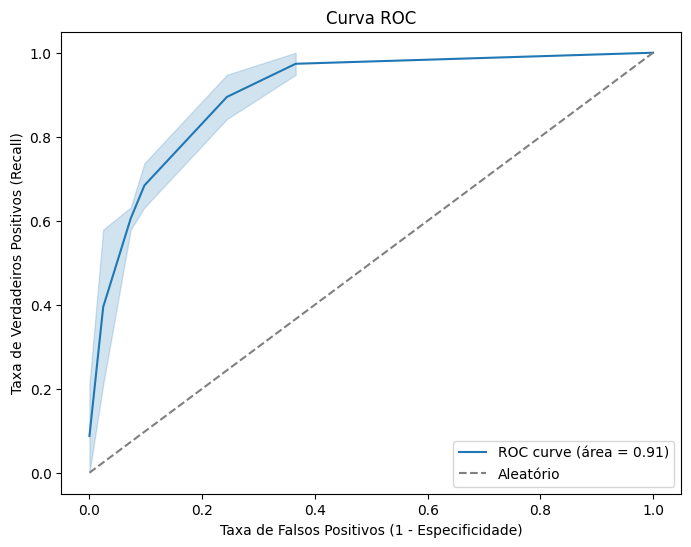

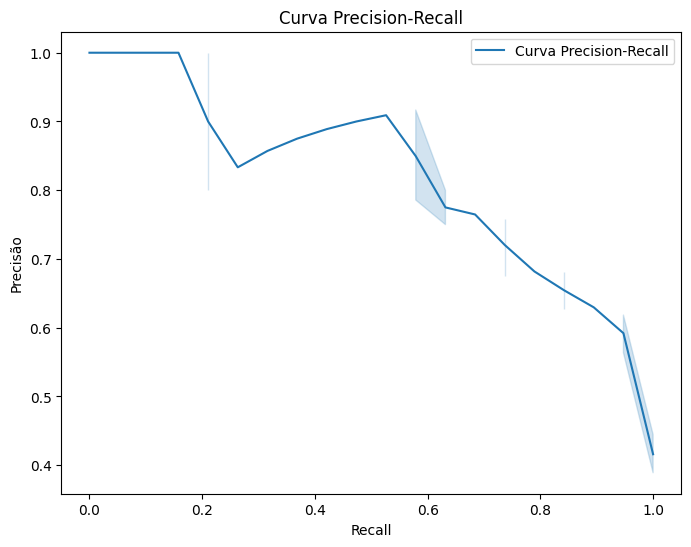

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Probabilidades da classe positiva (ajuste [1] se o target for binário)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# ===== Curva ROC =====
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (área = {roc_auc:.2f})')
sns.lineplot(x=[0,1], y=[0,1], color='gray', linestyle='--', label='Aleatório')
plt.xlabel("Taxa de Falsos Positivos (1 - Especificidade)")
plt.ylabel("Taxa de Verdadeiros Positivos (Recall)")
plt.title("Curva ROC")
plt.legend()
plt.show()

# ===== Curva Precision-Recall =====
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8,6))
sns.lineplot(x=recall, y=precision, label="Curva Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Curva Precision-Recall")
plt.legend()
plt.show()


**Curva ROC:** mostra a capacidade do modelo em distinguir entre classes.  
A área sob a curva (AUC = 0,89) indica excelente separação.  

**Curva Precision-Recall:** mostra o trade-off entre recall e precisão.  
Dependendo do problema, podemos ajustar o limiar de decisão para priorizar recall (detectar mais positivos) ou precisão (reduzir falsos positivos).

11.2. Escolha do limiar ótimo

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Teste diferentes thresholds e escolha o que maximiza o F1-score
f1_scores = []
for thr in thresholds_pr:
    preds = (y_pred_proba >= thr).astype(int)
    f1_scores.append(f1_score(y_test, preds))

best_thr = thresholds_pr[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Melhor limiar para maximizar F1: {best_thr:.2f} (F1 = {best_f1:.3f})")


Melhor limiar para maximizar F1: 0.27 (F1 = 0.766)


### 11.3. Próximos passos

Para dar continuidade a este trabalho, os próximos passos recomendados são:

1. **Ampliar a base de dados**: incorporar mais observações e variáveis relevantes para reduzir viés e aumentar a generalização.  
2. **Explorar modelos mais avançados**: avaliar ensembles como XGBoost e LightGBM, além de redes neurais simples.  
3. **Aprimorar a validação**: aplicar k-fold cross-validation para resultados mais robustos.  
4. **Ajustar o limiar de decisão**: calibrar o threshold de classificação de acordo com a necessidade do negócio (priorizar recall ou precisão).  
5. **Explicabilidade**: incluir técnicas como SHAP ou LIME para interpretar a importância das variáveis.  

---

Com esses próximos passos, o modelo pode evoluir de um MVP para uma solução de machine learning mais robusta, interpretável e aplicável em um cenário real.


## 12. Salvando artefatos (modelos e pipeline)

Para evitar retreinar em execuções futuras, salvamos o **pipeline completo** (pré-processamento + modelo).


In [ ]:
import joblib
joblib.dump(best_model, "best_model_pipeline.joblib")
print("Salvo: best_model_pipeline.joblib")

# Exemplo de carregamento e uso:
loaded = joblib.load("best_model_pipeline.joblib")
pred_demo = loaded.predict(X_test[:5])
print("Predições de teste (5 amostras):", pred_demo)

Salvo: best_model_pipeline.joblib
Predições de teste (5 amostras): [0 0 0 0 0]
